In [5]:
# abpc_dashboard.py
# Modular, fast dashboard for MoRF/LeRF + ABPC areas (matplotlib + W&B).

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple, Optional

class ABPCDashboard:
    """
    Build a 2x2 matplotlib dashboard of MoRF/LeRF mean±std curves and ABPC area stats,
    grouped by `aggregation_function`, filtered by group ('ABPC') and supervoxel type.

    x-axis modes:
      - 'absolute': truncate each subgroup to its common MIN length across runs
      - 'percent' : resample each run to the subgroup's MAX length (or a fixed N points)
    """

    # Colors (MoRF blue, LeRF red, purple gap)
    MORF_COLOR = "#1f77b4"
    LERF_COLOR = "#d62728"
    GAP_COLOR  = "purple"
    BAND_ALPHA = 0.18
    GAP_ALPHA  = 0.12

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group: str = "ABPC",
        subgroups: Optional[List[str]] = None,
        morf_key: str = "MoRF",
        lerf_key: str = "LeRF",
        abpc_key: str = "ABPC_area",
        page_size: int = 256,
    ):
        self.entity = entity
        self.project = project
        self.group = group
        self.subgroups = subgroups or [
            "true_positive_aggregation",
            "false_positive_aggregation",
            "dice_aggregation",
            "logit_difference_aggregation",
        ]
        self.MORF_KEY = morf_key
        self.LERF_KEY = lerf_key
        self.ABPC_KEY = abpc_key
        self.PAGE_SIZE = page_size
        self._api = wandb.Api()

    # ---------- Public API ----------

    def run(
        self,
        supervoxel_type: str,
        x_mode: str = "absolute",
        percent_points: Optional[int] = None,
        save: bool = True,
        dpi: int = 300,
    ):
        """
        Build and (optionally) save the dashboard for a single supervoxel type.

        Args:
            supervoxel_type: e.g., "full-organs", "FCC-organs"
            x_mode: "absolute" or "percent"
            percent_points: if x_mode="percent", resample to this many points (default: subgroup's L_max)
            save: save a PNG named abpc_dashboard_{x_mode}_{sv}.png
            dpi: figure DPI when saving
        """
        runs = self._fetch_runs(supervoxel_type)
        grouped = self._collect_curves(runs, x_mode=x_mode, percent_points=percent_points)

        # Console summary
        print(f"\n== ABPC area per subgroup (sv={supervoxel_type}, x_mode={x_mode}) ==")
        for sg in self.subgroups:
            vals = grouped[sg]["abpc_values"]
            if not vals:
                print(f"{sg:30s} : n=0")
            elif len(vals) == 1:
                print(f"{sg:30s} : mean={vals[0]:.4e} (n=1)")
            else:
                print(f"{sg:30s} : mean={np.mean(vals):.4e}  std={np.std(vals, ddof=1):.4e}  n={len(vals)}")

        fig = self._plot(grouped, supervoxel_type, x_mode)

        if save:
            safe_sv = supervoxel_type.replace(" ", "_")
            fname = f"abpc_dashboard_{x_mode}_{safe_sv}.png"
            fig.savefig(fname, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname}")

        plt.show()

    # ---------- Internals ----------

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        """Server-side filtering to keep it fast."""
        path = f"{self.entity}/{self.project}"
        filt = {
            "config.group": {"$eq": self.group},
            "config.supervoxel_type": {"$eq": supervoxel_type},
            "config.aggregation_function": {"$in": self.subgroups},
        }
        return list(self._api.runs(path, filters=filt))

    @staticmethod
    def _resample_to_length(y: np.ndarray, L_target: int) -> np.ndarray:
        """Linear interpolation of 1D array y onto L_target points over [0,1]."""
        L_run = len(y)
        if L_run <= 0:
            return np.zeros(L_target, dtype=float)
        if L_run == 1:
            return np.full(L_target, float(y[0]), dtype=float)
        x_src = np.linspace(0.0, 1.0, L_run)
        x_tgt = np.linspace(0.0, 1.0, L_target)
        return np.interp(x_tgt, x_src, y)

    def _collect_curves(
        self,
        runs: List[wandb.apis.public.Run],
        x_mode: str,
        percent_points: Optional[int],
    ) -> Dict[str, Dict]:
        """
        Assemble per-subgroup arrays:
            grouped[sg]["curves"]: (n, L, 2)   (MoRF, LeRF)
            grouped[sg]["abpc_values"]: list of floats
        """
        assert x_mode in {"absolute", "percent"}

        curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in self.subgroups}
        abpc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        lengths: Dict[str, List[int]] = {sg: [] for sg in self.subgroups}

        # First pass: collect variable-length sequences per run
        for r in runs:
            sg = (r.config or {}).get("aggregation_function")
            if sg not in curves_raw:
                continue

            morf_vals, lerf_vals = {}, {}
            abpc_last = None

            for row in r.scan_history(page_size=self.PAGE_SIZE):
                step = row.get("_step", row.get("step"))
                if step is None:
                    continue
                if self.MORF_KEY in row and row[self.MORF_KEY] is not None:
                    morf_vals[step] = float(row[self.MORF_KEY])
                if self.LERF_KEY in row and row[self.LERF_KEY] is not None:
                    lerf_vals[step] = float(row[self.LERF_KEY])
                if self.ABPC_KEY in row and row[self.ABPC_KEY] is not None:
                    abpc_last = float(row[self.ABPC_KEY])

            common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
            if len(common) >= 1:
                morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
                lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
                seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
                curves_raw[sg].append(seq)
                lengths[sg].append(len(common))

            if abpc_last is not None:
                abpc_vals[sg].append(abpc_last)

        # Second pass: align by x_mode
        grouped: Dict[str, Dict] = {sg: {"curves": np.empty((0, 2, 2)), "abpc_values": abpc_vals[sg]}
                                    for sg in self.subgroups}

        for sg in self.subgroups:
            seqs = curves_raw[sg]
            if not seqs:
                grouped[sg]["curves"] = np.empty((0, 2, 2), dtype=float)
                continue

            if x_mode == "absolute":
                # Truncate to the MIN length (common prefix)
                L = min(lengths[sg])
                seqs_trunc = [seq[:L] for seq in seqs]
                grouped[sg]["curves"] = np.stack(seqs_trunc, axis=0)  # (n, L, 2)
            else:
                # Resample each run to subgroup's MAX length (or the user-provided fixed N)
                L_target = percent_points if (percent_points and percent_points > 1) else max(lengths[sg])
                resampled = []
                for seq in seqs:
                    morf_rs = self._resample_to_length(seq[:, 0], L_target)
                    lerf_rs = self._resample_to_length(seq[:, 1], L_target)
                    resampled.append(np.stack([morf_rs, lerf_rs], axis=1))  # (L_target, 2)
                grouped[sg]["curves"] = np.stack(resampled, axis=0)  # (n, L_target, 2)

        return grouped

    @staticmethod
    def _summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """curves: (n, L, 2) → (morf_mean, morf_std, lerf_mean, lerf_std)"""
        if curves.size == 0:
            return (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
        morf = curves[:, :, 0]  # (n, L)
        lerf = curves[:, :, 1]  # (n, L)
        morf_mean = morf.mean(axis=0)
        lerf_mean = lerf.mean(axis=0)
        morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
        lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
        return morf_mean, morf_std, lerf_mean, lerf_std

    def _plot(self, grouped: Dict[str, Dict], supervoxel_type: str, x_mode: str):
        """Create and return the 2x2 matplotlib Figure."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False, sharey=False)
        axes = axes.ravel()

        titles = {
            "true_positive_aggregation": "True Positive Aggregation",
            "false_positive_aggregation": "False Positive Aggregation",
            "dice_aggregation": "Dice Aggregation",
            "logit_difference_aggregation": "Logit Difference Aggregation",
        }

        for ax, sg in zip(axes, self.subgroups):
            curves = grouped[sg]["curves"]  # (n, L, 2)
            if curves.size == 0:
                ax.set_title(titles.get(sg, sg) + " (no data)")
                ax.grid(True, alpha=0.25)
                continue

            L = curves.shape[1]
            if x_mode == "percent":
                x_vals = np.linspace(0, 100, L)
                x_label = "Percent of steps"
            else:
                x_vals = np.arange(L)
                x_label = "Step"

            morf_mean, morf_std, lerf_mean, lerf_std = self._summarize_curves(curves)

            # std bands
            ax.fill_between(x_vals, morf_mean - morf_std, morf_mean + morf_std,
                            color=self.MORF_COLOR, alpha=self.BAND_ALPHA)
            ax.fill_between(x_vals, lerf_mean - lerf_std, lerf_mean + lerf_std,
                            color=self.LERF_COLOR, alpha=self.BAND_ALPHA)

            # mean lines
            ax.plot(x_vals, morf_mean, linewidth=2.0, color=self.MORF_COLOR, label="MoRF (mean)")
            ax.plot(x_vals, lerf_mean, linewidth=2.0, color=self.LERF_COLOR, label="LeRF (mean)")

            # purple gap
            gap_low  = np.minimum(morf_mean, lerf_mean)
            gap_high = np.maximum(morf_mean, lerf_mean)
            ax.fill_between(x_vals, gap_low, gap_high, color=self.GAP_COLOR, alpha=self.GAP_ALPHA)

            # ABPC stats box
            vals = grouped[sg]["abpc_values"]
            if vals:
                mean_abpc = np.mean(vals)
                std_abpc  = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
                ax.text(0.02, 0.98, f"ABPC area\nμ={mean_abpc:.3e}\nσ={std_abpc:.3e}\n(n={len(vals)})",
                        transform=ax.transAxes, ha="left", va="top",
                        bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
                        fontsize=9)

            ax.set_title(titles.get(sg, sg))
            ax.grid(True, alpha=0.25)
            ax.set_xlabel(x_label)
            ax.set_ylabel("Score")

        # shared legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))
        title_mode = "% steps" if x_mode == "percent" else "absolute steps"
        fig.suptitle(f"ABPC — MoRF/LeRF (Mean ± Std, {title_mode}) by Aggregation Function — SV: {supervoxel_type}",
                     y=1.04, fontsize=14)
        fig.tight_layout()
        return fig

In [6]:
dash = ABPCDashboard(entity="giuliosichili", project="automi", group="ABPC")


== ABPC area per subgroup (sv=full-organs, x_mode=absolute) ==
true_positive_aggregation      : mean=2.0937e-05  std=3.1790e-05  n=8
false_positive_aggregation     : mean=4.2391e-06  std=1.1890e-05  n=8
dice_aggregation               : mean=1.6720e-01  std=3.0472e-01  n=8
logit_difference_aggregation   : mean=1.9995e-05  std=3.1022e-05  n=8
[saved] abpc_dashboard_absolute_full-organs.png


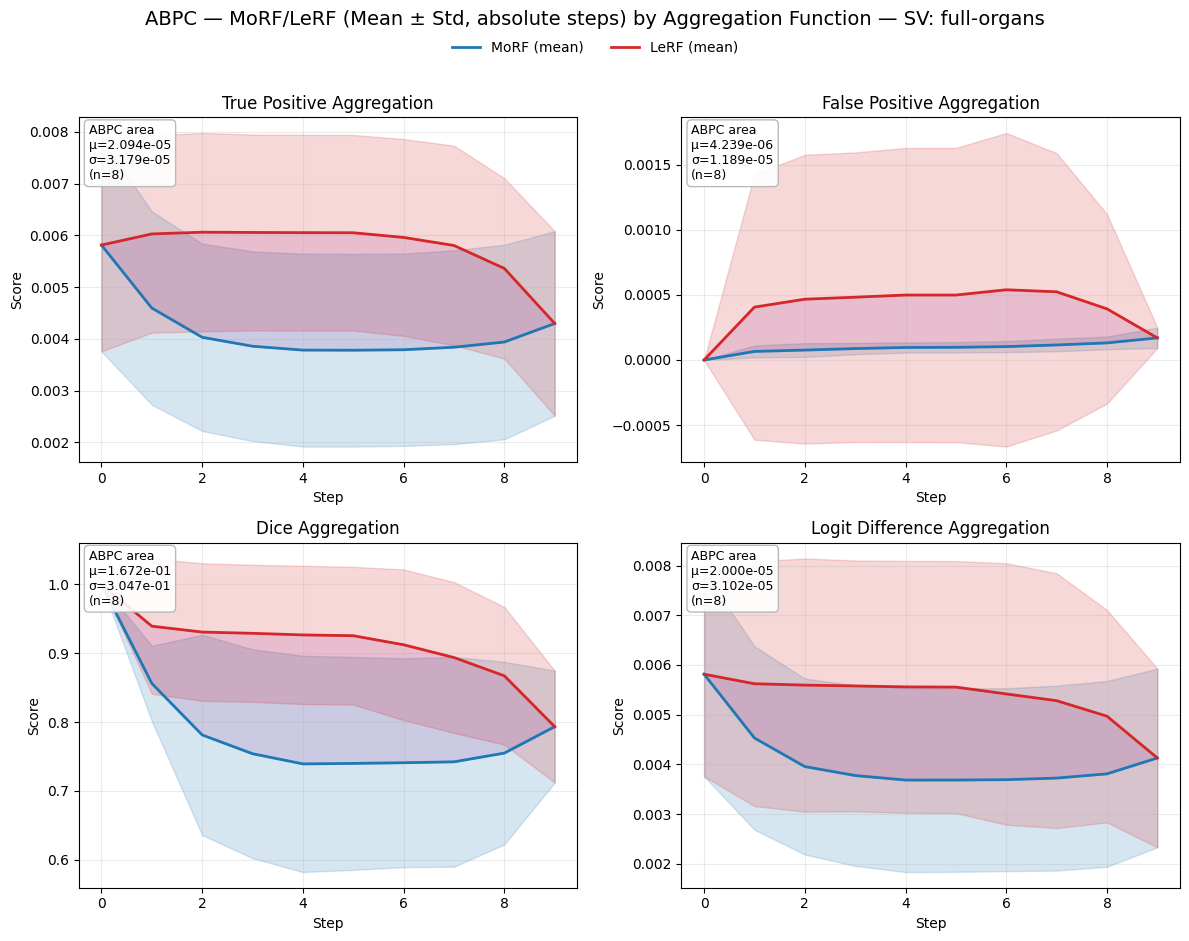

In [7]:

dash.run(supervoxel_type="full-organs", x_mode="absolute")         # truncate to min length

## Save some observations about starting and ending points!

* the two curves start and end in the same point (all on and all off respectively)
* FP aggr. starts on 0, as there can't be spurious predictions for the original input with respect to itself
* Dice Aggregation starts on 1, because the baseline volume produces perfect overlapping with itself.
* TP and Logit Difference start on the same point, here 0.0059 approximately. This is because for the unperturbed volume, all the logits are in the baseline segmentation mask, so their sum is equal to the sum returned by True Positive mask.

these observation are maybe of limited interest, but they strengthen the reliability of these new defined metrics as the behavior is the one expected

## Other observations
* TP plot is very regular, in the sense that LeRF and MoRF curves are mostly simmetric around a point between them. This suggests that this notion of importance, given by preservation of predicted regions, is the most natural from a perspective that considers additivity of the parts (organs in this case) important, and also imply little feature interactions since attribution order is well respected in these plots.
* FP range, which is scaled equally to TP and Logit Difference and it's a logit sum like them, so it's comparable as unit, is very low compared to them. This shows limited spurious lymph nodes predictions, at least not close to baseline segmentation mask mass.
* Dice and LogDiff show a similar shape, and it's expected since the second is a continuous version of the first. We notice a decreasing monotonic behavior in LeRF curve, while the MoRF shows a decreasing and then increasing plot in the least important organs.



== ABPC area per subgroup (sv=FCC-organs, x_mode=percent) ==
true_positive_aggregation      : mean=8.3440e-01  std=4.8760e-01  n=8
false_positive_aggregation     : mean=3.7537e-02  std=7.3060e-02  n=8
dice_aggregation               : mean=7.6441e+01  std=4.6952e+01  n=8
logit_difference_aggregation   : mean=7.6874e-01  std=5.1712e-01  n=8
[saved] abpc_dashboard_percent_FCC-organs.png


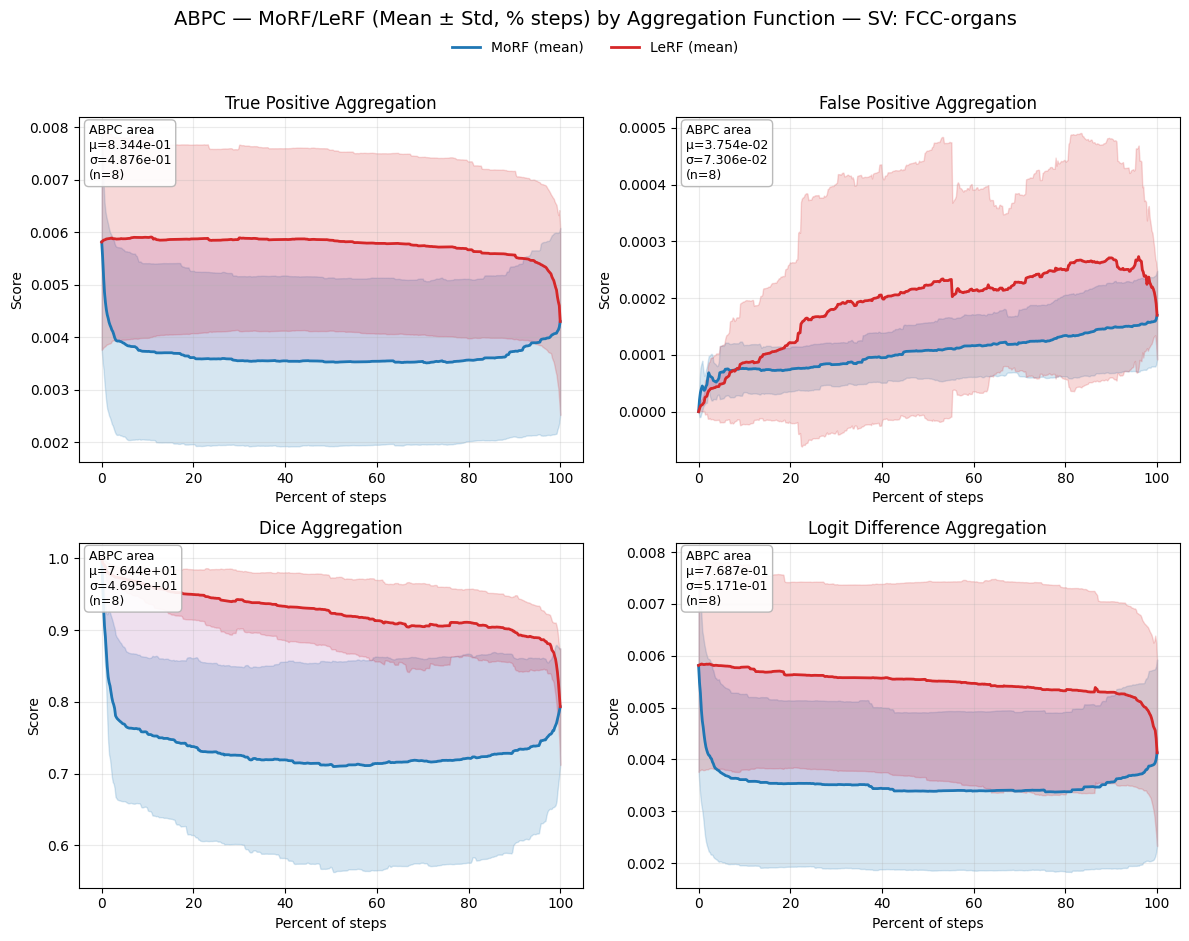

In [8]:

dash.run(supervoxel_type="FCC-organs", x_mode="percent")           # interpolate to subgroup max


== ABPC area per subgroup (sv=FCC, x_mode=percent) ==
true_positive_aggregation      : mean=1.4997e+00  std=6.1130e-01  n=5
false_positive_aggregation     : mean=2.9000e-01  std=4.6071e-01  n=5
dice_aggregation               : mean=2.5411e+02  std=7.7740e+01  n=5
logit_difference_aggregation   : mean=1.3194e+00  std=7.0588e-01  n=4
[saved] abpc_dashboard_percent_FCC.png


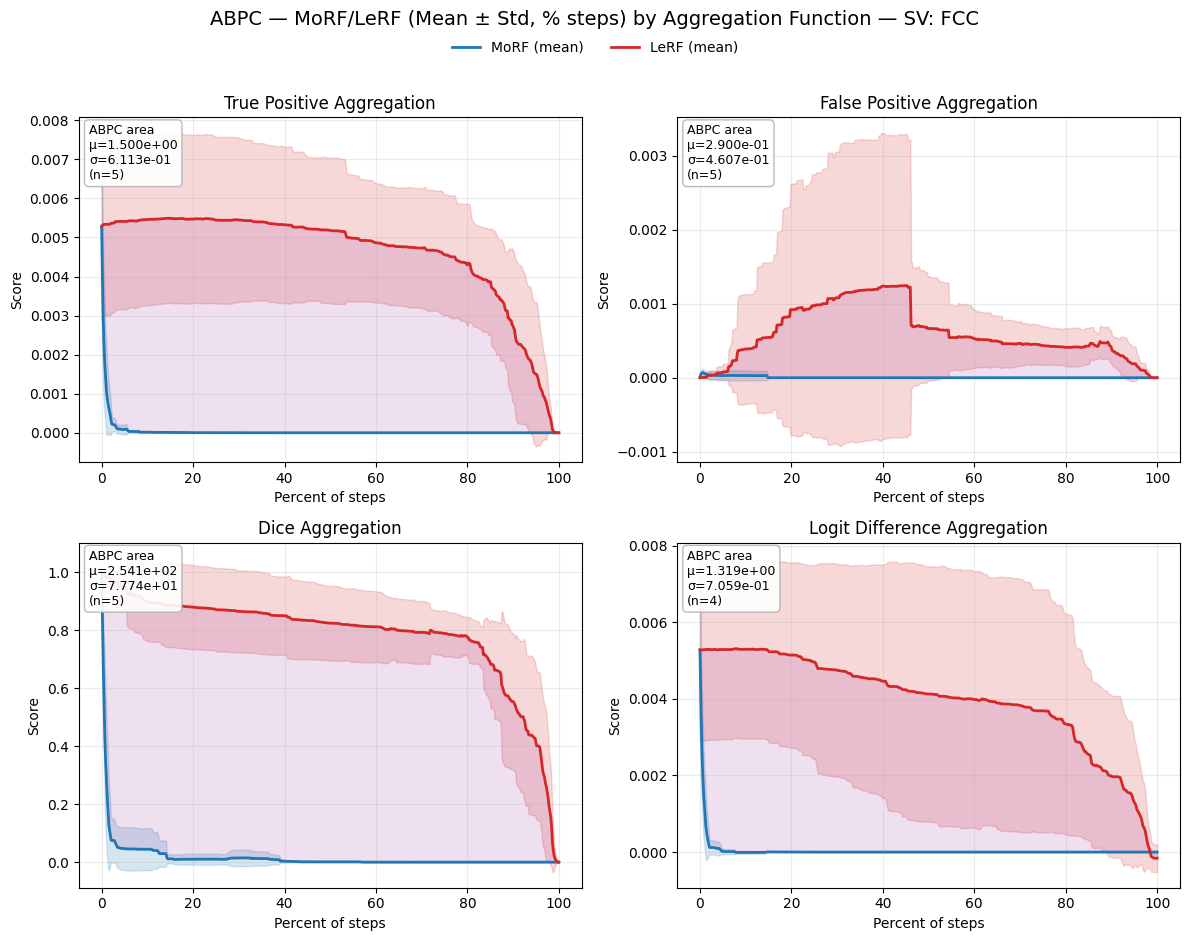

In [9]:

dash.run(supervoxel_type="FCC", x_mode="percent")